In [1]:
import numpy as np
import random
import os 
import torch
import torch.nn as nn
from torch import Tensor
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, ConcatDataset
import torch.nn.functional as F
from torch.cuda.amp.grad_scaler import GradScaler
from torch.cuda.amp import autocast

from torchsummary import summary
from sklearn.metrics import r2_score

from ray import tune

import json
import itertools
from itertools import groupby
import gzip 
from io import BytesIO
from time import time 

import matplotlib.pyplot as plt

import pyBigWig
from scipy.sparse import csc_matrix
import math 

import torch.cuda.amp as amp

import functools

In [2]:
from modules import * 
from model import *

In [3]:
param_vals = { 
"classification_data_type": None,         
"mode": "regression",
"optimizer" : "Adam", 
"init_lr": 0.001, 
"optimizer_momentum": 0.9, 
"weight_decay": 1e-3, 
"loss": "poisson", 
"num_targets": [23, 14], 
"lambda_param": 0.001, 
"ltype":1,
"clip": 2.,
"seq_len": 128 * 128 * 8,
"target_window": 128 * 16,
"batch_size": 4,
"cut": 0.8,
"num_workers": 0,
"num_epochs": 8
}

In [15]:
num_targets_total = np.sum(param_vals.get("num_targets"))
num_epochs = param_vals.get("num_epochs")
opt = param_vals.get("optimizer")
lr = str(param_vals.get("init_lr")).split('.')[-1]


In [5]:
# trainer_dir = '/data/users/goodarzilab/darya/work/basenji_pytorch/models
res_dir = '/data/users/goodarzilab/darya/work/basenji_pytorch/Result Arrs'

In [6]:
def mean_arr(num_epochs, arr):
        num_iter = int(len(arr) / num_epochs)
        mean_train_arr = [np.mean(arr[i*num_iter:(i+1)*num_iter]) for i in range(num_epochs)]
        return mean_train_arr
            
def plot_metrics(num_epochs, train_arrs, val_arrs): 
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
    for i in range(3):
        mean_train_arr = mean_arr(num_epochs, train_arrs[i])
        mean_val_arr = mean_arr(num_epochs, val_arrs[i])
        axs[i].plot(np.arange(num_epochs-1), mean_train_arr[1:], label='Train')
        axs[i].plot(np.arange(num_epochs-1), mean_val_arr[1:], label='Val')
    fig.tight_layout()
    plt.show() 

In [18]:
train_arrs_name = "basenji_{}targets_{}epochs_{}_lr_{}_train_arr.npy".format(
    num_targets_total, num_epochs, opt, lr)
val_arrs_name = "basenji_{}targets_{}epochs_{}_lr_{}_val_arr.npy".format(
    num_targets_total, num_epochs, opt, lr)

In [19]:
train_arrs = np.load(os.path.join(res_dir ,train_arrs_name))
val_arrs = np.load(os.path.join(res_dir ,val_arrs_name))

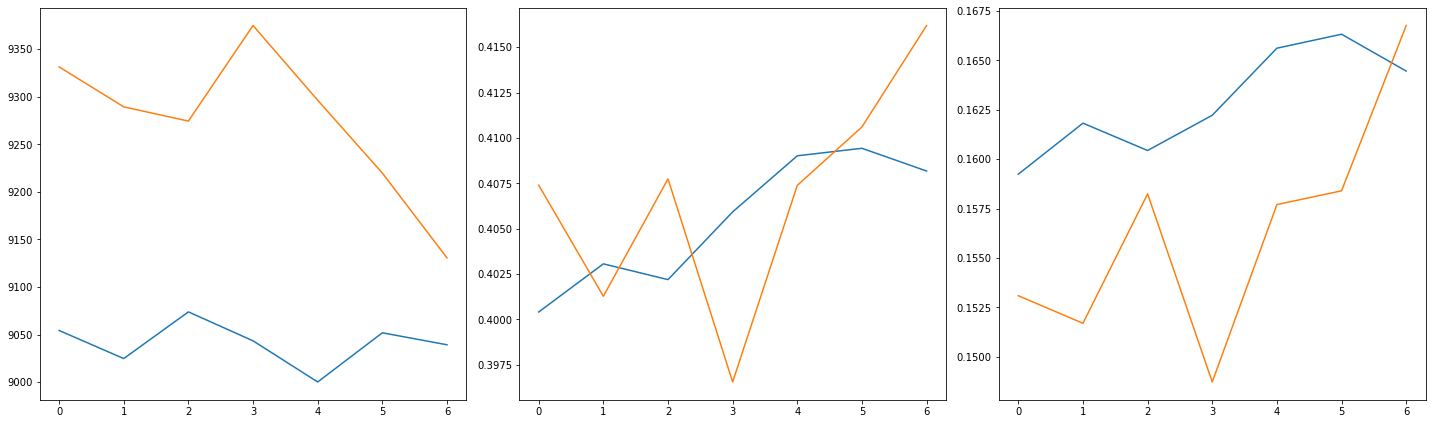

In [20]:
plot_metrics(num_epochs, train_arrs, val_arrs)